Testing different convolutions 

In [2]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from skimage.transform import downscale_local_mean

import warnings
warnings.filterwarnings('ignore')
# initializing parameters:

psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
kern = create_matching_kernel(psf,psf_hsc)
psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()


dataroot = 'gals_optim/' # path to dataset
workers = 4
batchSize = 64           # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 100
ngpu = 3       #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

In [3]:
### read in an image with HST resoluion and downgrade (resample, PSF convolve, add noise) to HSC 
dataset = dset.MNIST(root=dataroot, download=True, transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=int(workers))

inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to(device)
ajab = real_cpu.detach()
ajab = ajab.cpu()

im = real_cpu+0.25*torch.rand_like(real_cpu)
downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
img = img[:,:,:,:]


torch.Size([1, 1, 21, 21]) torch.Size([1, 1, 101, 101])


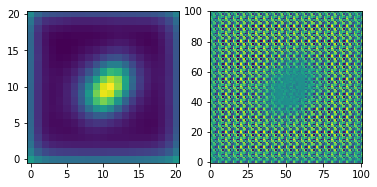

In [11]:
plt.subplot(1,2,1)
plt.imshow(img[0,0,:,:],origin='lower')

F = nn.ConvTranspose2d( 1, 1, 5, 5, 2, bias=False)
a = F(img)
print(img.shape,a.shape)
aj = a.detach()
plt.subplot(1,2,2)
plt.imshow(aj[0,0,:,:],origin='lower')

tensor([[[[ 9.7613e-04,  2.0755e-03,  2.4251e-03,  ..., -3.3391e-03,
           -2.5442e-03,  9.6747e-05],
          [ 1.4402e-03,  1.5863e-03,  1.0162e-03,  ..., -4.0621e-03,
           -4.0275e-03, -8.2746e-04],
          [ 2.4224e-03,  1.5847e-03,  6.4311e-04,  ..., -3.2386e-03,
           -4.7270e-03, -2.1995e-03],
          ...,
          [ 2.8316e-03,  4.5871e-04, -4.8040e-04,  ...,  5.9090e-04,
           -8.5353e-04, -2.5855e-03],
          [ 2.7908e-03,  3.9864e-04,  2.1132e-05,  ..., -2.3912e-04,
           -1.2525e-03, -2.8110e-03],
          [ 2.8273e-03,  9.8010e-04,  7.4670e-04,  ...,  1.0642e-03,
            2.9670e-04, -8.7963e-04]],

         [[ 9.5423e-04,  2.6316e-03,  3.2821e-03,  ...,  3.3153e-05,
           -4.5207e-04, -5.3377e-04],
          [ 2.0096e-03,  2.8417e-03,  2.3447e-03,  ...,  5.7493e-04,
           -3.8952e-04, -4.8698e-04],
          [ 2.5273e-03,  2.4134e-03,  1.8268e-03,  ...,  6.0999e-04,
           -3.8160e-04, -2.9036e-05],
          ...,
     